In [9]:
# import required libraries
import PyQt5
import numpy as np
import cv2  # Added to support visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
from matplotlib.animation import FuncAnimation
from aniposelib.boards import CharucoBoard
from aniposelib.cameras import Camera, CameraGroup, interpolate_data, resample_points_extra
from aniposelib.utils import load_pose2d_fnames, get_initial_extrinsics
from aniposelib.boards import merge_rows, extract_points, extract_rtvecs

In [10]:
# set up video names, board, cameras, camera group, and extract rows
videos = [['R0530_20240401_13-04-14_calibration-charuco-camA.mp4'],
          ['R0530_20240401_13-04-14_calibration-charuco-camC.mp4'],
          ['R0530_20240401_13-04-14_calibration-charuco-camD.mp4']]

cam_names = ['A', 'C','D']

n_cams = len(videos)

board = CharucoBoard(10, 7,
                     square_length=16, # here, in mm but any unit works
                     marker_length=12,
                     marker_bits=4, dict_size=50)

# make list of cameras
cameras = []
for name in cam_names:
    cam = Camera(name=name)
    cameras.append(cam)

cgroup = CameraGroup(cameras)

all_rows = cgroup.get_rows_videos(videos, board, verbose=True)

cgroup.set_camera_sizes_videos(videos)

R0530_20240401_13-04-14_calibration-charuco-camA.mp4


100%|███████████████████████████████| 211/211 [00:11<00:00, 18.51it/s]


182 boards detected
R0530_20240401_13-04-14_calibration-charuco-camC.mp4


100%|███████████████████████████████| 211/211 [00:14<00:00, 14.68it/s]


189 boards detected
R0530_20240401_13-04-14_calibration-charuco-camD.mp4


100%|███████████████████████████████| 211/211 [00:24<00:00,  8.56it/s]

180 boards detected


In [11]:
# stuff in calibrate_rows (actually calibrate cameras & estimate pose)
for rows, camera in zip(all_rows, cameras):
    size = camera.get_size()

    # Added check for size
    assert size is not None, \
        "Camera with name {} has no specified frame size".format(camera.get_name())

    objp, imgp = board.get_all_calibration_points(rows)
    mixed = [(o, i) for (o, i) in zip(objp, imgp) if len(o) >= 9]

    # Added check for mixed being empty
    if not mixed:
        print(f"No valid calibration points found for camera {camera.get_name()}")
        continue

    objp, imgp = zip(*mixed)
    matrix = cv2.initCameraMatrix2D(objp, imgp, tuple(size))
    camera.set_camera_matrix(matrix.copy())
    camera.zero_distortions()

    # print(cgroup.get_dicts())

    for i, (row, cam) in enumerate(zip(all_rows, cameras)):
        all_rows[i] = board.estimate_pose_rows(cam, row)

    new_rows = [[r for r in rows if r['ids'].size >= 8] for rows in all_rows]
    merged = merge_rows(new_rows)
    imgp, extra, unshaped_imgp = extract_points(merged, board, min_cameras=2)

    # if init_extrinsics:
    rtvecs = extract_rtvecs(merged)
    # # if verbose:
    # pprint(get_connections(rtvecs, cgroup.get_names()))

    rvecs, tvecs = get_initial_extrinsics(rtvecs, cgroup.get_names())
    cgroup.set_rotations(rvecs)
    cgroup.set_translations(tvecs)

    # interpolate_data(imgp)
    # print("Resampling points")
    # resample_points_extra(imgp, extra)

    error = cgroup.bundle_adjust_iter(imgp, extra)

print("Calibration complete")
print("visualizing the imgp points")

Shape of imgp before reshape: (3, 206, 54, 2)
Shape of objp before reshape: (206, 54, 3)
Number of good points after filtering: 9316
Final shapes - imgp: (3, 9316, 2), objp: (9316, 3), rvecs: (3, 9316, 3), tvecs: (3, 9316, 3)
Shape of imgp before reshape: (3, 206, 54, 2)
Shape of objp before reshape: (206, 54, 3)
Number of good points after filtering: 9316
Final shapes - imgp: (3, 9316, 2), objp: (9316, 3), rvecs: (3, 9316, 3), tvecs: (3, 9316, 3)
Shape of imgp before reshape: (3, 206, 54, 2)
Shape of objp before reshape: (206, 54, 3)
Number of good points after filtering: 9316
Final shapes - imgp: (3, 9316, 2), objp: (9316, 3), rvecs: (3, 9316, 3), tvecs: (3, 9316, 3)
Calibration complete
visualizing the imgp points


In [12]:
# some data processing

def save_imgp_to_file(imgp, filename):
    """
    Save imgp points to a readable text file.
    """
    # Check if imgp is a numpy array, if not, convert it
    if not isinstance(imgp, np.ndarray):
        imgp = np.array(imgp)
    
    # Open the file in write mode
    with open(filename, 'w') as file:
        # Write a header line for clarity
        file.write("Image Points (x, y):\n")
        
        # Write each point to the file
        for point_set in imgp:
            for point in point_set:
                file.write(f"{point[0]}, {point[1]}\n")
save_imgp_to_file(imgp, "imgp_points.txt")

# get a list of the correct frames
correct_frames = [[],[],[]]
count = 0

for camera in all_rows:
    # For each camera list, iterate over its items
    for item in camera:
        # Extract the second number of 'framenum' and append it to the result list
        correct_frames[count].append(item['framenum'][1])
    
    # Increment the count
    count += 1

In [13]:
# visualize imgp points functions

def visualize_calibration_points(all_obj, all_img):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for obj, img in zip(all_obj, all_img):
        ax.scatter(obj[:, 0], obj[:, 1], obj[:, 2], c='b', marker='o')
        ax.scatter(img[:, 0], img[:, 1], np.zeros_like(img[:, 0]), c='r', marker='x')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Calibration Points')
    ax.legend(['Object Points', 'Image Points'])
    plt.show()

def visualize_cameras(all_img):
    num_cameras = len(all_img)
    for cam_idx, img_points in enumerate(all_img):
        plt.figure()
        plt.scatter(img_points[:, 0], img_points[:, 1], c='b', marker='o')
        plt.title(f"Camera {cam_idx + 1}")
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

def visualize_triangulated_points(triangulated_points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(triangulated_points[:, 0], triangulated_points[:, 1], triangulated_points[:, 2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Triangulated Points')
    plt.show()

def visualize_triangulated_points_in_batches(triangulated_points, batch_size=54):
    num_points = triangulated_points.shape[0]
    num_batches = (num_points + batch_size - 1) // batch_size  # Ceiling division

    def plot_batch(batch_num):
        start = batch_num * batch_size
        end = min(start + batch_size, num_points)
        points_batch = triangulated_points[start:end]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points_batch[:, 0], points_batch[:, 1], points_batch[:, 2], c='b', marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Triangulated Points (Batch {batch_num + 1}/{num_batches})')
        plt.show()

    batch_num = 0
    while True:
        plot_batch(batch_num)
        user_input = input("Enter 'n' for next batch, 'p' for previous batch, or 'q' to quit: ").strip().lower()
        if user_input == 'n':
            if batch_num < num_batches - 1:
                batch_num += 1
            else:
                print("Already at the last batch.")
        elif user_input == 'p':
            if batch_num > 0:
                batch_num -= 1
            else:
                print("Already at the first batch.")
        elif user_input == 'q':
            break
        else:
            print("Invalid input. Please enter 'n', 'p', or 'q'.")

def overlay_points_on_video_write(video_paths, all_img, output_paths, points_per_frame=54, correct_frames=None):
    for cam_idx, (video_path, img_points, output_path) in enumerate(zip(video_paths, all_img, output_paths)):
        cap = cv2.VideoCapture(video_path[0])
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path[0]}")
            continue

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames in input video
        
        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        num_frames = total_frames # OR hardcode: (len(img_points) // points_per_frame) + 100

        frame_count = 0

        for frame_idx in range(num_frames):

            ret, frame = cap.read()
            if not ret:
                break

            if not frame_idx in correct_frames[cam_idx]:
                out.write(frame)
                continue

            start_idx = (frame_count) * points_per_frame
            end_idx = start_idx + points_per_frame
            points = img_points[start_idx:end_idx]

            for point in points:
                if not np.isnan(point).any():
                    x, y = int(point[0]), int(point[1])
                    cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

            out.write(frame)
            frame_count += 1

        cap.release()
        out.release()

def overlay_points_on_video_read(video_paths, all_img, output_paths, points_per_frame=54, correct_frames=None):
    for cam_idx, (video_path, img_points, output_path) in enumerate(zip(video_paths, all_img, output_paths)):
        cap = cv2.VideoCapture(video_path[0])
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path[0]}")
            continue

        # video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames in input video
        
        # codec and create videoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        for frame_idx, frame_num in enumerate(correct_frames[cam_idx]):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1) # 0-based index?
            ret, frame = cap.read()
            if not ret:
                break

            start_idx = (frame_idx) * points_per_frame
            end_idx = start_idx + points_per_frame
            points = img_points[start_idx:end_idx]

            for point in points:
                if not np.isnan(point).any():
                    x, y = int(point[0]), int(point[1])
                    cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

            out.write(frame)

        cap.release()
        out.release()

def overlay_points_on_video_source(video_paths, all_img, output_paths, all_rows=None, correct_frames=None):
    for cam_idx, (video_path, img_points, output_path) in enumerate(zip(video_paths, all_img, output_paths)):
        cap = cv2.VideoCapture(video_path[0])
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path[0]}")
            continue

        # video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # codec and create videoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        for frame_idx, frame_num in enumerate(correct_frames[cam_idx]):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) # 0-based index?
            ret, frame = cap.read()
            if not ret:
                break

            # go into the all_rows and get the filled points from the correct frame
            for item in all_rows[cam_idx][frame_idx]['filled']:
                first = item[0][0]
                last = item[0][1]
                point = np.array([first, last])
                if not np.isnan(point).any():      
                    x, y = int(first), int(last)
                    cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
            
            out.write(frame)

        cap.release()
        out.release()

def overlay_points_on_video_merged(video_paths, output_paths, merged):
    for cam_idx, (video_path, output_paths) in enumerate(zip(video_paths, output_paths)):
        cap = cv2.VideoCapture(video_path[0])
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path[0]}")
            continue

        cap.set(cv2.CAP_PROP_POS_FRAMES, 130) # 0-based index?
        ret, frame = cap.read()
        if not ret:
            break
    
        for item in merged[125][cam_idx]['filled']:
            first = item[0][0]
            last = item[0][1]
            point = np.array([first, last])
            if not np.isnan(point).any():      
                x, y = int(first), int(last)
                cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

        cv2.imwrite(output_paths, frame)

        cap.release()

Shape of imgp before reshape: (3, 54, 2)
Shape of imgp before reshape: (3, 54, 2)
Shape of imgp before reshape: (3, 54, 2)
Shape of imgp after reshape: (3, 54, 2)


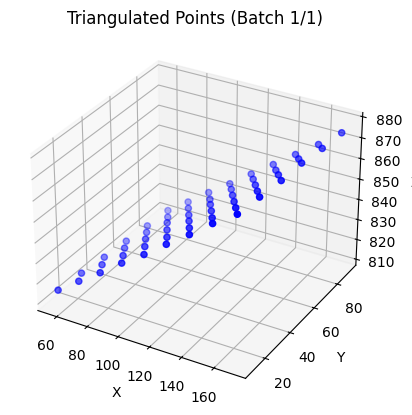

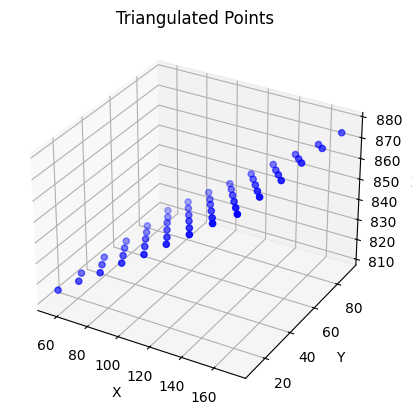

In [15]:
# using the overlay functions to visualize the points

# take 1 frame out from each camera
# triangulate the points for that frame and see if they are on the same plane

# use data from unshaped_imgp and take out frame 125

output_frames = ['imagea.jpg', 'imagec.jpg', 'imaged.jpg']
# instantiate new_imgp as a np array with the same shape as imgp
new_imgp = np.zeros((3, 54, 2))
for cam_idx, (video_path, output_paths) in enumerate(zip(videos, output_frames)):
    cap = cv2.VideoCapture(video_path[0])
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path[0]}")
        continue

    cap.set(cv2.CAP_PROP_POS_FRAMES, 130) # 0-based index?

    # triangulation visualization is wrong since frame index is not the same as its actual frame number
    # since some points were removed, my visualization by grouping is wonk

    ret, frame = cap.read()
    if not ret:
        break

    point_idx = 0
    for item in merged[125][cam_idx]['filled']:
        first = item[0][0]
        last = item[0][1]
        point = np.array([first, last])
        # how do i add each point to the new_imgp np array?
        if not np.isnan(point).any():      
            x, y = int(first), int(last)
            cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
            new_imgp[cam_idx, point_idx] = point
            point_idx += 1

        
    
    print(f"Shape of imgp before reshape: {new_imgp.shape}")

    cv2.imwrite(output_paths, frame)

    cap.release()


print(f"Shape of imgp after reshape: {new_imgp.shape}")

points3d = cgroup.triangulate(new_imgp)
# points_3d, picked, p2ds, errors = cgroup.triangulate_ransac(
#                 imgp, min_cams=3, progress=True)

output_paths = ['output_camAs.mp4', 'output_camCs.mp4', 'output_camDs.mp4']

# overlay_points_on_video_merged(videos, output_frames, merged)
# overlay_points_on_video_write(videos, imgp, output_paths, correct_frames=correct_frames)
# overlay_points_on_video_read(videos, imgp, output_paths, correct_frames=correct_frames)
# overlay_points_on_video_source(videos, imgp, output_paths, all_rows=all_rows, correct_frames=correct_frames)
# visualize_triangulated_points_in_batches(points3d)
visualize_triangulated_points(points3d) # should be a plane
# visualize_cameras(imgp) # each camera should have a set of points
# visualize_calibration_points(objp, imgp)




